### Libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics

from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.exceptions import YellowbrickWarning

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from imblearn.over_sampling import SMOTE

2024-11-14 05:24:25.420043: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 05:24:25.454436: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 05:24:25.505499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731561865.557880   11824 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731561865.571758   11824 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 05:24:25.629197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Data Analysis and Processing

In [2]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [4]:
print(df.columns)

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')


In [5]:
print('\n Train Dataset summary : \n')

pd.concat([
            pd.DataFrame(df.count()).T.rename(index={0: 'count'}),
           pd.DataFrame(df.nunique()).T.rename(index={0: 'number of unique'}),
           pd.DataFrame(df.dtypes).T.rename(index={0: 'dtype'}),
           pd.DataFrame(df.isna().sum()).T.rename(index={0: 'null count'}),
           df.describe().drop('count')
          ]).T


 Train Dataset summary : 



,count,number of unique,dtype,null count,mean,std,min,25%,50%,75%,max
id,58645,58645,int64,0,29322.0,16929.497605,0.0,14661.0,29322.0,43983.0,58644.0
person_age,58645,53,int64,0,27.550857,6.033216,20.0,23.0,26.0,30.0,123.0
person_income,58645,2641,int64,0,64046.172871,37931.106978,4200.0,42000.0,58000.0,75600.0,1900000.0
person_home_ownership,58645,4,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,58645,36,float64,0,4.701015,3.959784,0.0,2.0,4.0,7.0,123.0
loan_intent,58645,6,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,58645,7,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,58645,545,int64,0,9217.556518,5563.807384,500.0,5000.0,8000.0,12000.0,35000.0
loan_int_rate,58645,362,float64,0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645,61,float64,0,0.159238,0.091692,0.0,0.09,0.14,0.21,0.83


In [6]:
print('\n Test Dataset summary : \n')

pd.concat([
            pd.DataFrame(test_df.count()).T.rename(index={0: 'count'}),
           pd.DataFrame(test_df.nunique()).T.rename(index={0: 'number of unique'}),
           pd.DataFrame(test_df.dtypes).T.rename(index={0: 'dtype'}),
           pd.DataFrame(test_df.isna().sum()).T.rename(index={0: 'null count'}),
           test_df.describe().drop('count')
          ]).T


 Test Dataset summary : 



,count,number of unique,dtype,null count,mean,std,min,25%,50%,75%,max
id,39098,39098,int64,0,78193.5,11286.764749,58645.0,68419.25,78193.5,87967.75,97742.0
person_age,39098,52,int64,0,27.566781,6.032761,20.0,23.0,26.0,30.0,94.0
person_income,39098,2196,int64,0,64060.460842,37955.828705,4000.0,42000.0,58000.0,75885.0,1900000.0
person_home_ownership,39098,4,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,39098,31,float64,0,4.687068,3.868395,0.0,2.0,4.0,7.0,42.0
loan_intent,39098,6,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,39098,7,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,39098,482,int64,0,9251.466188,5576.25468,700.0,5000.0,8000.0,12000.0,35000.0
loan_int_rate,39098,336,float64,0,10.661216,3.02022,5.42,7.88,10.75,12.99,22.11
loan_percent_income,39098,63,float64,0,0.159573,0.091633,0.0,0.09,0.14,0.21,0.73


In [7]:
df.drop(columns = ['id'], inplace=True)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [8]:
print('Categorical value of person_home_ownership: ', df.person_home_ownership.unique())
print('Categorical value of loan_intent: ', df.loan_intent.unique())
print('Categorical value of loan_grade: ', df.loan_grade.unique())
print('Categorical value of cb_person_default_on_file: ', df.cb_person_default_on_file.unique())

Categorical value of person_home_ownership:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Categorical value of loan_intent:  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
Categorical value of loan_grade:  ['B' 'C' 'A' 'D' 'E' 'F' 'G']
Categorical value of cb_person_default_on_file:  ['N' 'Y']


In [9]:
df_tensor = df.copy()

cb_person_default_on_file_mapping = {'Y' : 1, 'N' : 0}
loan_grade_mapping = {'A' : 7, 'B' : 6, 'C' : 5, 'D' : 4, 'E' : 3, 'F' : 2, 'G' : 1}
person_home_ownership_mapping = {'OWN' : 4, 'MORTGAGE' : 3, 'RENT' : 2, 'OTHER' : 1}

In [10]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(cb_person_default_on_file_mapping)
df['loan_grade'] = df['loan_grade'].map(loan_grade_mapping)
df['person_home_ownership'] = df['person_home_ownership'].map(person_home_ownership_mapping)

In [11]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,2,0.0,EDUCATION,6,6000,11.49,0.17,0,14,0
1,22,56000,4,6.0,MEDICAL,5,4000,13.35,0.07,0,2,0
2,29,28800,4,8.0,PERSONAL,7,6000,8.90,0.21,0,10,0
3,30,70000,2,14.0,VENTURE,6,12000,11.11,0.17,0,5,0
4,22,60000,2,2.0,MEDICAL,7,6000,6.92,0.10,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,3,5.0,EDUCATION,4,25000,15.95,0.21,1,10,0
58641,28,28800,2,0.0,MEDICAL,5,10000,12.73,0.35,0,8,1
58642,23,44000,2,7.0,EDUCATION,4,6800,16.00,0.15,0,2,1
58643,22,30000,2,2.0,EDUCATION,7,5000,8.90,0.17,0,3,0


In [12]:
label_encoder = LabelEncoder()
df['loan_intent'] = label_encoder.fit_transform(df['loan_intent'])

In [13]:
df.duplicated().sum()

0

In [14]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,2,0.0,1,6,6000,11.49,0.17,0,14,0
1,22,56000,4,6.0,3,5,4000,13.35,0.07,0,2,0
2,29,28800,4,8.0,4,7,6000,8.90,0.21,0,10,0
3,30,70000,2,14.0,5,6,12000,11.11,0.17,0,5,0
4,22,60000,2,2.0,3,7,6000,6.92,0.10,0,3,0


### Visualization

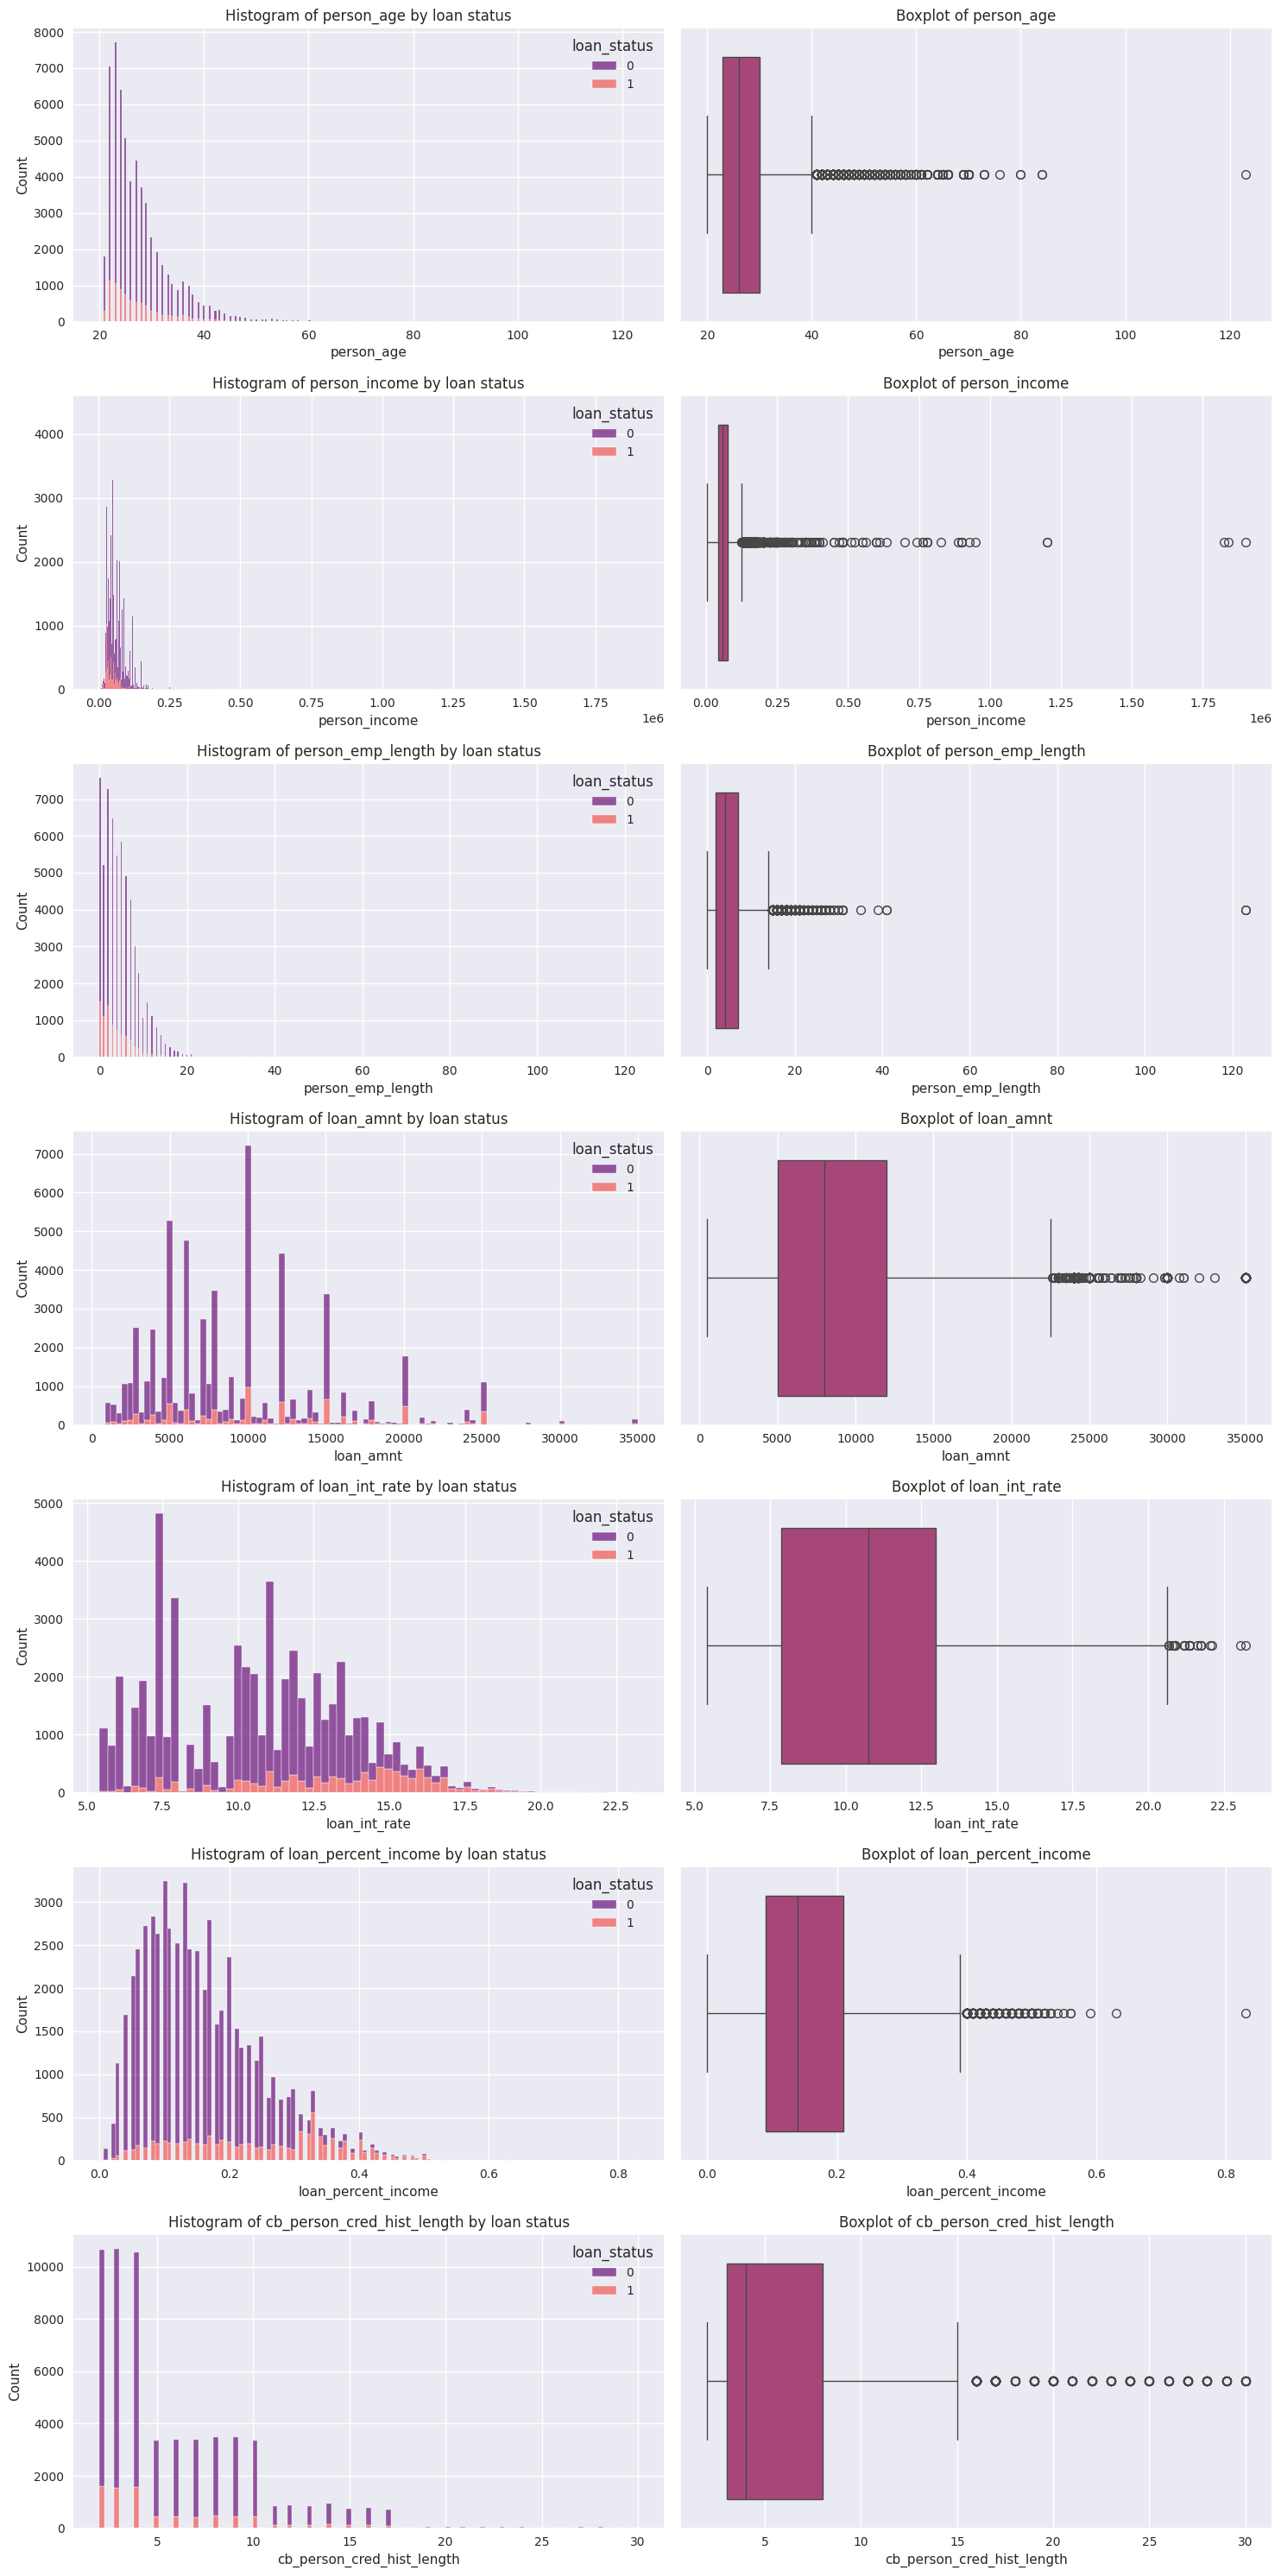

In [15]:
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('darkgrid')

list_of_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
fig, axs = plt.subplots(len(list_of_columns), 2, figsize=(15, 30))

for i, columns_name in enumerate(list_of_columns):
    sns.histplot(data=df, x=columns_name, hue='loan_status',
                 multiple='stack', palette='magma', ax=axs[i, 0])

    axs[i, 0].set_title(f'Histogram of {columns_name} by loan status')

    sns.boxplot(data=df, x=columns_name, palette='magma', ax=axs[i, 1])

    axs[i, 1].set_title(f'Boxplot of {columns_name}')

plt.tight_layout()

plt.show()

warnings.simplefilter(action='default', category=FutureWarning)

In [16]:
df = df[df.person_age < 100]
df = df[df.person_emp_length < 100]

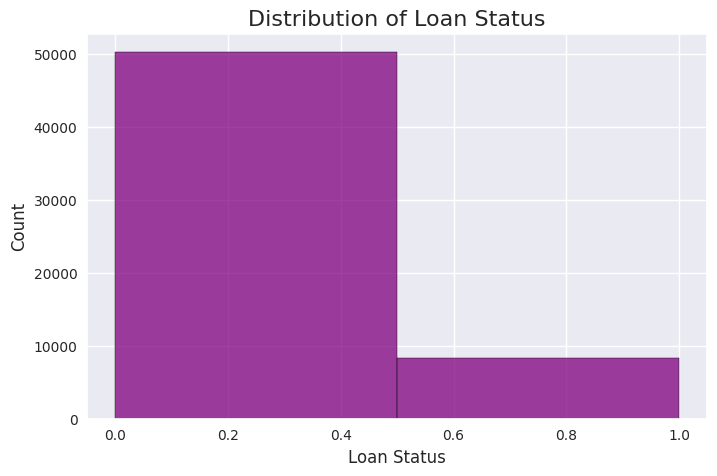

In [17]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(8, 5))

sns.histplot(data=df, x='loan_status', bins=2, color='purple', edgecolor='black')

plt.title('Distribution of Loan Status', fontsize=16)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

warnings.simplefilter(action='default', category=FutureWarning)

### Logistic Regression

In [18]:
nan_counts = df.isna().sum()
print(nan_counts)

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


Solver: lbfgs, Penalty: l2, C: 1:   0%|          | 0/120 [00:00<?, ?it/s]

Solver: saga, Penalty: None, C: 10: 100%|██████████| 120/120 [01:23<00:00,  1.45it/s]      


Total training time: 83.04 seconds


,solver,penalty,C,accuracy,precision,recall,TN,FP,FN,TP
0,liblinear,l2,7,0.899736,0.727363,0.447642,9822,274,902,731
1,liblinear,l1,2,0.899736,0.726014,0.449479,9819,277,899,734
2,liblinear,l2,9,0.899736,0.726912,0.448255,9821,275,901,732
3,liblinear,l2,6,0.899650,0.727092,0.447030,9822,274,903,730
4,sag,l2,6,0.899650,0.726640,0.447642,9821,275,902,731
...,...,...,...,...,...,...,...,...,...,...
115,lbfgs,l2,2,0.898627,0.724242,0.439069,9823,273,916,717
116,saga,l2,1,0.898542,0.725331,0.436620,9826,270,920,713
117,newton-cg,l2,1,0.898542,0.725331,0.436620,9826,270,920,713
118,sag,l2,1,0.898542,0.725331,0.436620,9826,270,920,713



 the best result is for liblinear Solver , penalty : l2 and C : 7 which has accuracy of : 0.8997356978429534




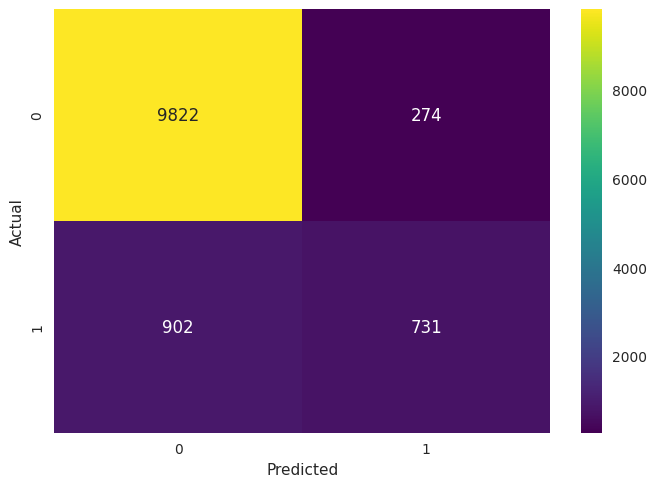

/opt/conda/envs/{env_name}/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


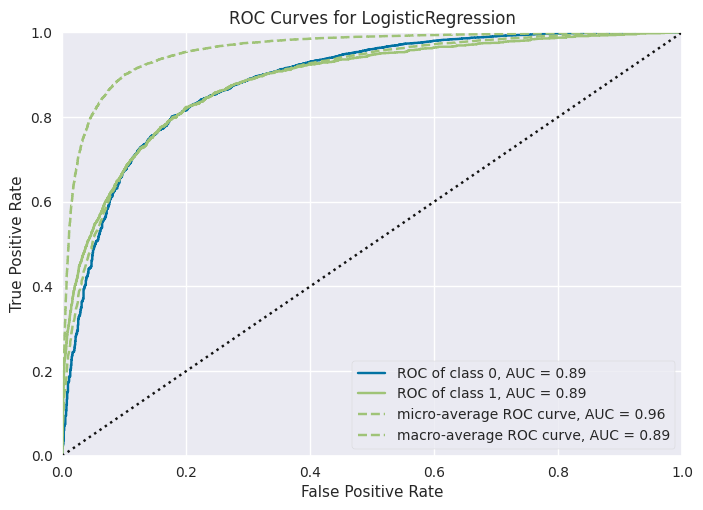

In [20]:
import time
from tqdm import tqdm

results = []

X = df.drop(columns=['loan_status'])
y = df['loan_status']

Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

x_train1, x_test1, y_train1, y_test1 = train_test_split(X_norm, y, test_size=0.2, random_state=42)

solver_penalties = [
    ('lbfgs', ['l2', None]),
    ('liblinear', ['l1', 'l2']),
    ('newton-cg', ['l2', None]),
    ('sag', ['l2', None]),
    ('saga', ['elasticnet', 'l1', 'l2', None])
]

# Calculate total iterations for progress bar
total_iterations = sum(len(penalties) * 10 for _, penalties in solver_penalties)

start_time = time.time()
with tqdm(total=total_iterations, desc='Training Progress') as pbar:
    for solver, penalties in solver_penalties:
        for C in np.arange(1, 11):
            for penalty in penalties:
                # Display current parameters
                pbar.set_description(f'Solver: {solver}, Penalty: {penalty}, C: {C}')
                
                if penalty == 'elasticnet':
                    l1_ratio = 0.5
                    clf = LogisticRegression(solver=solver, C=C, random_state=42, penalty=penalty, l1_ratio=l1_ratio, max_iter=10000)
                elif penalty is None:
                    clf = LogisticRegression(solver=solver, random_state=42, max_iter=10000, penalty=None)
                else:
                    clf = LogisticRegression(solver=solver, random_state=42, max_iter=10000, penalty=penalty, C=C)

                clf.fit(x_train1, y_train1)
                y_pred1 = clf.predict(x_test1)
                cm = metrics.confusion_matrix(y_test1, y_pred1)
                accuracy = metrics.accuracy_score(y_test1, y_pred1)
                precision = metrics.precision_score(y_test1, y_pred1)
                recall = metrics.recall_score(y_test1, y_pred1)
                results.append((solver, penalty, C, accuracy, precision, recall, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))
                
                pbar.update(1)

elapsed_time = time.time() - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds")

results_df = pd.DataFrame(results, columns=['solver', 'penalty', 'C', 'accuracy', 'precision', 'recall', 'TN', 'FP', 'FN', 'TP'])
results_df.sort_values(by='accuracy', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
display(results_df)

print(f'\n the best result is for {results_df["solver"][0]} Solver , penalty : {results_df["penalty"][0]} and C : {results_df["C"][0]} which has accuracy of :', results_df['accuracy'][0])
print('\n')

sns.heatmap([[results_df['TN'][0], results_df['FP'][0]],
             [results_df['FN'][0], results_df['TP'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

best_solver = results_df["solver"][0]
best_clf = LogisticRegression(solver=best_solver, max_iter=1000, C=10, random_state=0)
best_clf.fit(x_train1, y_train1)
y_pred_best = best_clf.predict(x_test1)

visualizer = ROCAUC(best_clf)
visualizer.fit(x_train1, y_train1)
visualizer.score(x_test1, y_test1)
visualizer.show();

### KNN

Testing with 1 neighbors:   0%|          | 0/20 [00:00<?, ?it/s]

Testing with 20 neighbors: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


Total training time: 129.85 seconds


,n_neighbors,test_accuracy,train_accuracy,precision,recall,TN,FP,FN,TP
10,11,0.936738,0.940443,0.895246,0.620122,9970,119,623,1017
12,13,0.936141,0.939569,0.891821,0.618293,9966,123,626,1014
8,9,0.935715,0.941232,0.879931,0.625610,9949,140,614,1026
6,7,0.935459,0.942447,0.870697,0.632317,9935,154,603,1037
14,15,0.935289,0.938525,0.890861,0.612195,9966,123,636,1004
11,12,0.934777,0.937842,0.913126,0.589634,9997,92,673,967
9,10,0.934692,0.938716,0.906134,0.594512,9988,101,665,975
16,17,0.934351,0.937459,0.894737,0.601220,9973,116,654,986
7,8,0.934265,0.939164,0.906455,0.590854,9989,100,671,969
19,20,0.934010,0.933878,0.911597,0.584756,9996,93,681,959



 the best result is for 1 neighbors which has accuracy of : 0.9024639781737573




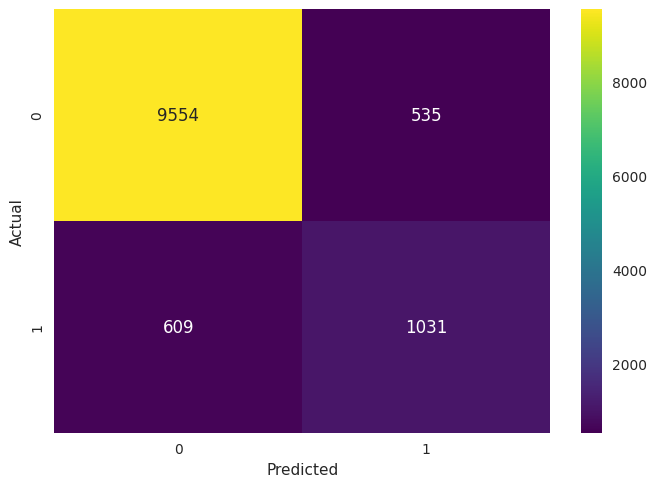

/opt/conda/envs/{env_name}/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


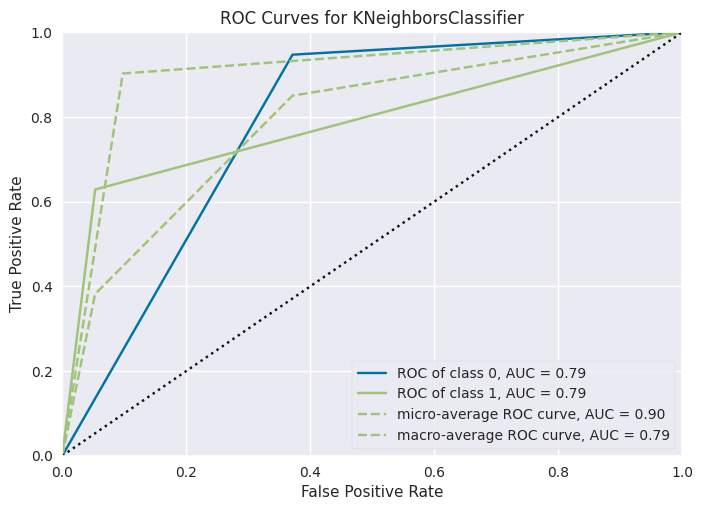

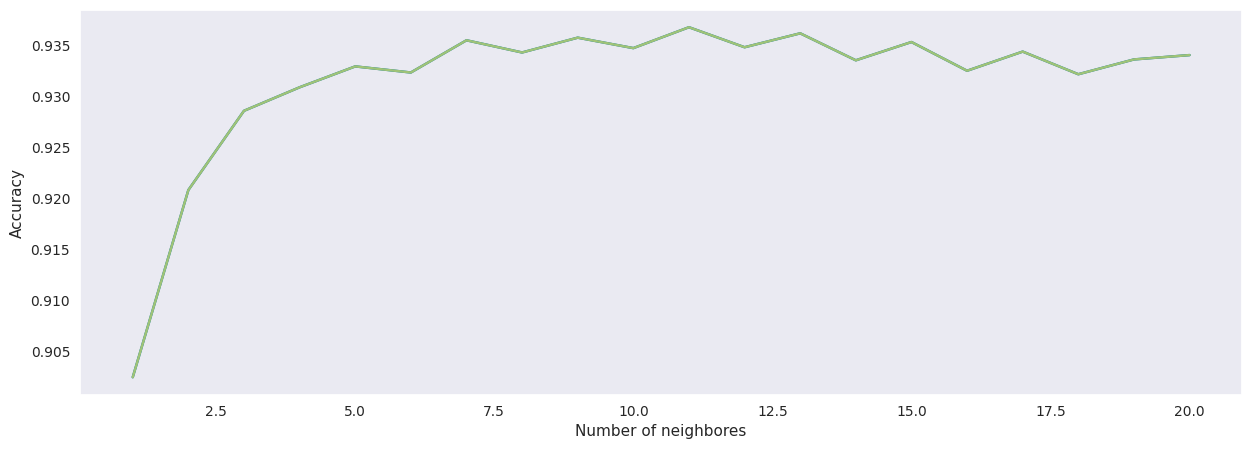

In [22]:
import time
from tqdm import tqdm

results = []

X = df.drop(columns=['loan_status'])
y = df['loan_status']

Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=0)

start_time = time.time()
# Add progress bar for 20 iterations
with tqdm(range(1, 21), desc='Training KNN Models') as pbar:
    for n_neighbors in pbar:
        # Update progress description
        pbar.set_description(f'Testing with {n_neighbors} neighbors')
        
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cm = metrics.confusion_matrix(y_test, y_pred)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        results.append((n_neighbors, clf.score(x_test, y_test), clf.score(x_train, y_train), 
                       precision, recall, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))

elapsed_time = time.time() - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds")

results_df = pd.DataFrame(results, columns = ['n_neighbors', 'test_accuracy', 'train_accuracy', 'precision', 'recall', 'TN', 'FP', 'FN', 'TP'])
results_df.sort_values(by = 'test_accuracy', ascending = False, inplace = True)
display(results_df)

print(f'\n the best result is for {results_df["n_neighbors"][0]} neighbors which has accuracy of :', results_df['test_accuracy'][0])
print('\n')

sns.heatmap([[results_df['TN'][0], results_df['FP'][0]],
            [results_df['FN'][0], results_df['TP'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

best_n_neighbors = results_df["n_neighbors"][0]
best_clf = KNeighborsClassifier(n_neighbors = best_n_neighbors)
best_clf.fit(x_train, y_train)
y_pred_best = best_clf.predict(x_test)

visualizer = ROCAUC(best_clf)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show();

results_df.sort_values(by = 'n_neighbors', ascending=True, inplace =True)
results_df.reset_index(drop = True, inplace =True)

plt.figure(figsize = (15, 5))
plt.plot(results_df['n_neighbors'], results_df['test_accuracy'], label = 'Accuracy of training set')
plt.plot(results_df['n_neighbors'], results_df['test_accuracy'], label = 'Accuracy of test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbores')
plt.grid()
plt.show()


### Boosting and Bagging Methods

Preparing data...

Training XGBoost model...
[0]	validation_0-logloss:0.29508	validation_0-error:0.06205	validation_1-logloss:0.29283	validation_1-error:0.06207


/opt/conda/envs/{env_name}/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:55:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.25098	validation_0-error:0.05340	validation_1-logloss:0.24994	validation_1-error:0.05405
[2]	validation_0-logloss:0.22339	validation_0-error:0.05133	validation_1-logloss:0.22311	validation_1-error:0.05150
[3]	validation_0-logloss:0.20499	validation_0-error:0.05116	validation_1-logloss:0.20520	validation_1-error:0.05158
[4]	validation_0-logloss:0.19303	validation_0-error:0.05114	validation_1-logloss:0.19384	validation_1-error:0.05141
[5]	validation_0-logloss:0.18297	validation_0-error:0.05097	validation_1-logloss:0.18520	validation_1-error:0.05175
[6]	validation_0-logloss:0.17680	validation_0-error:0.05077	validation_1-logloss:0.17987	validation_1-error:0.05201
[7]	validation_0-logloss:0.17030	validation_0-error:0.05016	validation_1-logloss:0.17467	validation_1-error:0.05073
[8]	validation_0-logloss:0.16667	validation_0-error:0.04996	validation_1-logloss:0.17203	validation_1-error:0.05073
[9]	validation_0-logloss:0.16378	validation_0-error:0.04969	validation_1

,Model,Penalty,C,Accuracy,Precision,Recall,TN,FP,FN,TP
0,LightGBM,None,None,0.951744,0.921739,0.714023,9997,99,467,1166
1,XGBoost,None,None,0.950038,0.901765,0.719535,9968,128,458,1175



The best result is for LightGBM with an accuracy of: 0.9517435416489044



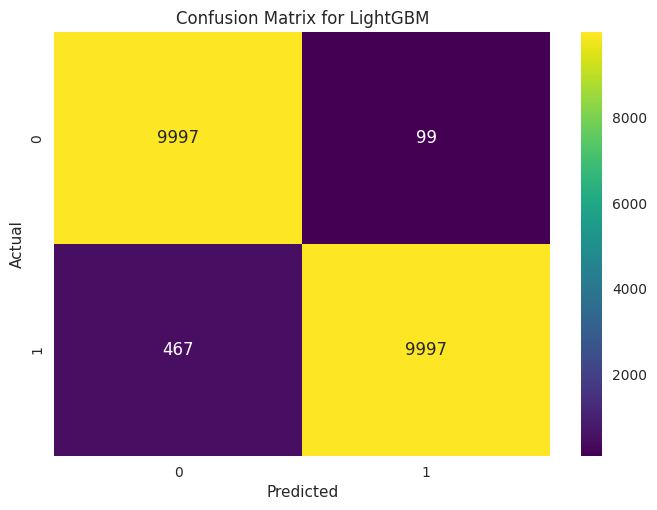

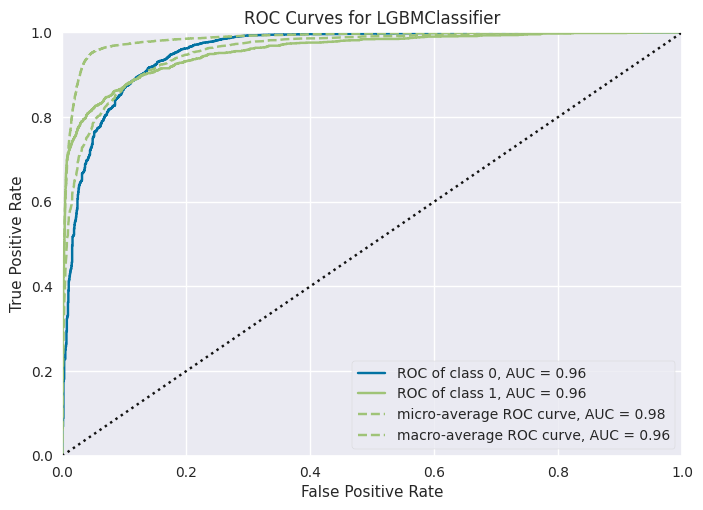

In [26]:
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

results = []
start_time = time.time()

print("Preparing data...")
X = df.drop(columns=['loan_status'])
y = df['loan_status']

Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

# XGBoost training with progress
print("\nTraining XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['logloss', 'error'],
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True
)

print("\nEvaluating XGBoost model...")
y_pred_xgb = xgb_model.predict(x_test)
cm_xgb = metrics.confusion_matrix(y_test, y_pred_xgb)
accuracy_xgb = metrics.accuracy_score(y_test, y_pred_xgb)
precision_xgb = metrics.precision_score(y_test, y_pred_xgb)
recall_xgb = metrics.recall_score(y_test, y_pred_xgb)
results.append(('XGBoost', None, None, accuracy_xgb, precision_xgb, recall_xgb, 
                cm_xgb[0, 0], cm_xgb[0, 1], cm_xgb[1, 0], cm_xgb[1, 1]))


# LightGBM training with progress
print("\nTraining LightGBM model...")
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    callbacks=[lgb.log_evaluation(period=10)]
)

print("\nEvaluating LightGBM model...")
y_pred_lgb = lgb_model.predict(x_test)
cm_lgb = metrics.confusion_matrix(y_test, y_pred_lgb)
accuracy_lgb = metrics.accuracy_score(y_test, y_pred_lgb)
precision_lgb = metrics.precision_score(y_test, y_pred_lgb)
recall_lgb = metrics.recall_score(y_test, y_pred_lgb)
results.append(('LightGBM', None, None, accuracy_lgb, precision_lgb, recall_lgb,
                cm_lgb[0, 0], cm_lgb[0, 1], cm_lgb[1, 0], cm_lgb[1, 1]))

# Calculate total time
total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds")

# Rest of the visualization code remains the same
results_df = pd.DataFrame(results, columns=['Model', 'Penalty', 'C', 'Accuracy', 
                                          'Precision', 'Recall', 'TN', 'FP', 'FN', 'TP'])
# Sort results by accuracy
results_df.sort_values(by = 'Accuracy', ascending = False, inplace = True)
results_df.reset_index(drop = True, inplace = True)
display(results_df)

print(f'\nThe best result is for {results_df["Model"][0]} with an accuracy of: {results_df["Accuracy"][0]}\n')

# Plot confusion matrix for the best model
sns.heatmap([[results_df['TN'][0], results_df['FP'][0]],
             [results_df['FN'][0], results_df['TN'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix for {results_df["Model"][0]}')
plt.show()

# Visualize ROC AUC for the best model
best_model_name = results_df["Model"][0]
if best_model_name == "XGBoost":
    best_model = xgb_model
else:
    best_model = lgb_model

visualizer = ROCAUC(best_model)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show();

/opt/conda/envs/{env_name}/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:56:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,penalty,C,Accuracy,Precision,Recall,True Negatives,False Positives,False Negatives,True Positives
0,Voting Classifier,None,None,0.953960,0.931711,0.72378,10002,87,453,1187
1,Random Forest,None,None,0.951403,0.934959,0.70122,10009,80,490,1150



The best result is for Voting Classifier with an accuracy of: 0.9539602694176826



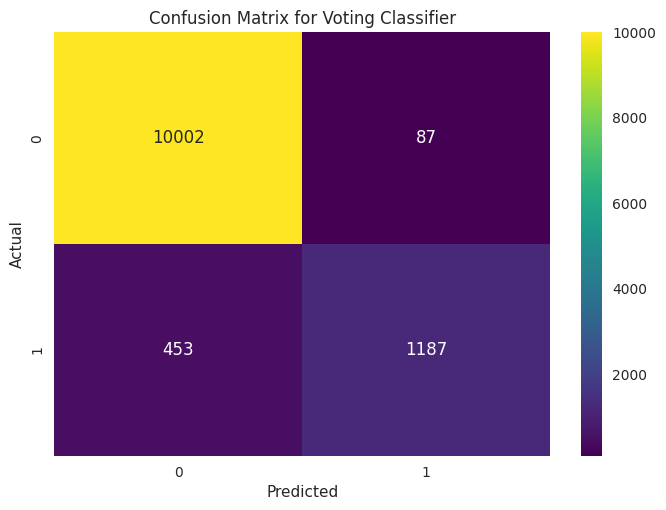

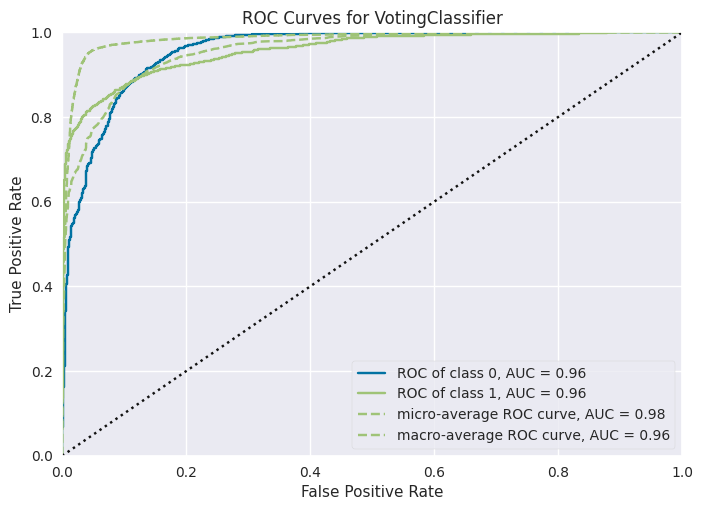

In [27]:
# Initialize results list
results = []

# Separate features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Normalize features
Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=0)

# Define and train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

# Evaluate Random Forest
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf)
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
precision_rf = metrics.precision_score(y_test, y_pred_rf)
recall_rf = metrics.recall_score(y_test, y_pred_rf)
results.append(('Random Forest', None, None, accuracy_rf, precision_rf, recall_rf, cm_rf[0, 0], cm_rf[0, 1], cm_rf[1, 0], cm_rf[1, 1]))

# Define and train Voting Classifier with XGBoost and LightGBM
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
        ('lgb', lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1))
    ],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

voting_model.fit(x_train, y_train)
y_pred_voting = voting_model.predict(x_test)

# Evaluate Voting Classifier
cm_voting = metrics.confusion_matrix(y_test, y_pred_voting)
accuracy_voting = metrics.accuracy_score(y_test, y_pred_voting)
precision_voting = metrics.precision_score(y_test, y_pred_voting)
recall_voting = metrics.recall_score(y_test, y_pred_voting)
results.append(('Voting Classifier', None, None, accuracy_voting, precision_voting, recall_voting, cm_voting[0, 0], cm_voting[0, 1], cm_voting[1, 0], cm_voting[1, 1]))

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Model', 'penalty', 'C', 'Accuracy', 'Precision', 'Recall', 'True Negatives',
                                            'False Positives', 'False Negatives', 'True Positives'])

# Sort results by accuracy
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
display(results_df)

print(f'\nThe best result is for {results_df["Model"][0]} with an accuracy of: {results_df["Accuracy"][0]}\n')

# Plot confusion matrix for the best model
sns.heatmap([[results_df['True Negatives'][0], results_df['False Positives'][0]],
             [results_df['False Negatives'][0], results_df['True Positives'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix for {results_df["Model"][0]}')
plt.show()

# Visualize ROC AUC for the best model
best_model_name = results_df["Model"][0]
if best_model_name == "Random Forest":
    best_model = rf_model
else:
    best_model = voting_model

visualizer = ROCAUC(best_model)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show();

,Model,penalty,C,Accuracy,Precision,Recall,True Negatives,False Positives,False Negatives,True Positives
0,CatBoost,None,None,0.955154,0.924543,0.739634,9990,99,427,1213
1,Voting Classifier,None,None,0.954728,0.939730,0.722561,10013,76,455,1185
2,Random Forest,None,None,0.951403,0.934959,0.701220,10009,80,490,1150



The best result is for CatBoost with an accuracy of: 0.9551538920624094



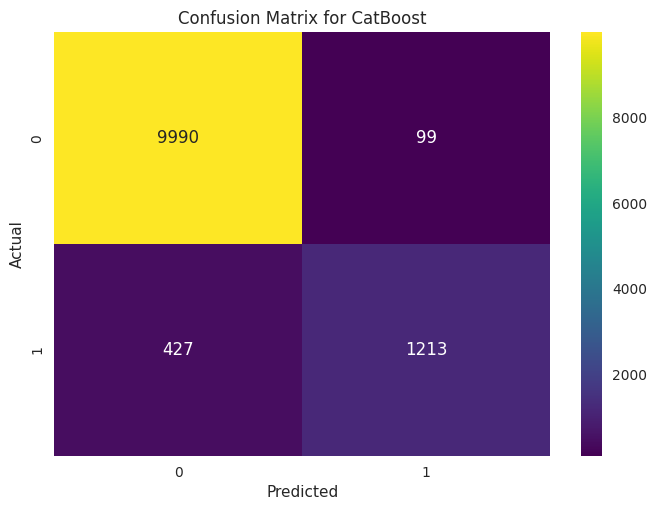

In [28]:
# Initialize results list
results = []

# Separate features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Normalize features
Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=0)

# Define and train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

# Evaluate Random Forest
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf)
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
precision_rf = metrics.precision_score(y_test, y_pred_rf)
recall_rf = metrics.recall_score(y_test, y_pred_rf)
results.append(('Random Forest', None, None, accuracy_rf, precision_rf, recall_rf, cm_rf[0, 0], cm_rf[0, 1], cm_rf[1, 0], cm_rf[1, 1]))

# Define and train CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, silent=True, random_state=0)
catboost_model.fit(x_train, y_train)
y_pred_catboost = catboost_model.predict(x_test)

# Evaluate CatBoost Classifier
cm_catboost = metrics.confusion_matrix(y_test, y_pred_catboost)
accuracy_catboost = metrics.accuracy_score(y_test, y_pred_catboost)
precision_catboost = metrics.precision_score(y_test, y_pred_catboost)
recall_catboost = metrics.recall_score(y_test, y_pred_catboost)
results.append(('CatBoost', None, None, accuracy_catboost, precision_catboost, recall_catboost, cm_catboost[0, 0], cm_catboost[0, 1], cm_catboost[1, 0], cm_catboost[1, 1]))

# Define and train Voting Classifier with Random Forest and CatBoost
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('catboost', catboost_model)
    ],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

voting_model.fit(x_train, y_train)
y_pred_voting = voting_model.predict(x_test)

# Evaluate Voting Classifier
cm_voting = metrics.confusion_matrix(y_test, y_pred_voting)
accuracy_voting = metrics.accuracy_score(y_test, y_pred_voting)
precision_voting = metrics.precision_score(y_test, y_pred_voting)
recall_voting = metrics.recall_score(y_test, y_pred_voting)
results.append(('Voting Classifier', None, None, accuracy_voting, precision_voting, recall_voting, cm_voting[0, 0], cm_voting[0, 1], cm_voting[1, 0], cm_voting[1, 1]))

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Model', 'penalty', 'C', 'Accuracy', 'Precision', 'Recall', 'True Negatives',
                                            'False Positives', 'False Negatives', 'True Positives'])

# Sort results by accuracy
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
display(results_df)

print(f'\nThe best result is for {results_df["Model"][0]} with an accuracy of: {results_df["Accuracy"][0]}\n')

# Plot confusion matrix for the best model
sns.heatmap([[results_df['True Negatives'][0], results_df['False Positives'][0]],
             [results_df['False Negatives'][0], results_df['True Positives'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix for {results_df["Model"][0]}')
plt.show();

In [29]:
test_df_tensor = test_df.copy()

test_df['cb_person_default_on_file'] = test_df['cb_person_default_on_file'].map(cb_person_default_on_file_mapping)
test_df['loan_grade'] = test_df['loan_grade'].map(loan_grade_mapping)
test_df['person_home_ownership'] = test_df['person_home_ownership'].map(person_home_ownership_mapping)
test_df['loan_intent'] = label_encoder.transform(test_df['loan_intent'])

In [30]:
test_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,2,3.0,2,2,25000,15.76,0.36,0,2
1,58646,26,96000,3,6.0,4,5,10000,12.68,0.10,1,4
2,58647,26,30000,2,5.0,5,3,4000,17.19,0.13,1,2
3,58648,33,50000,2,4.0,0,7,7000,8.90,0.14,0,7
4,58649,26,102000,3,8.0,2,4,15000,16.32,0.15,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,3,2.0,0,6,3000,10.37,0.10,0,4
39094,97739,22,48000,3,6.0,1,7,7000,6.03,0.15,0,3
39095,97740,51,60000,3,0.0,4,7,15000,7.51,0.25,0,25
39096,97741,22,36000,3,4.0,4,4,14000,15.62,0.39,1,4


In [32]:
# Initialize results list
results = []

# Separate features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Normalize features
Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

# Define and train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_norm, y)

# Define and train CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, silent=True, random_state=0)
catboost_model.fit(X_norm, y)

# Define and train Voting Classifier with Random Forest and CatBoost
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('catboost', catboost_model)
    ],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

voting_model.fit(X_norm, y)
x_test = test_df.drop(columns=['id'])

# Normalize features
norm_x = Scaler.transform(x_test)
x_test = pd.DataFrame(norm_x, columns=list(x_test.columns))

y_pred_voting = voting_model.predict_proba(x_test)[:, 1]

In [33]:
y_pred_voting

array([0.96909331, 0.02307092, 0.68738852, ..., 0.00237674, 0.18451388,
       0.96488551])

In [34]:
test_id = test_df.id
loan_status_column = y_pred_voting.flatten()

submission1 = pd.DataFrame({
    'id': test_id,
    'loan_status': loan_status_column
})

print(submission1)

          id  loan_status
0      58645     0.969093
1      58646     0.023071
2      58647     0.687389
3      58648     0.020381
4      58649     0.141769
...      ...          ...
39093  97738     0.023521
39094  97739     0.001668
39095  97740     0.002377
39096  97741     0.184514
39097  97742     0.964886

[39098 rows x 2 columns]


In [35]:
submission1.to_csv('data/submission1.csv', index=False)